## Лабораторна робота №1
* Тема: Генеративні алгоритми. Наївний Баєсів класифікатор.
* Мета: Ознайомитись з методами ймовірнісної регресії, що передбачають не лише значення, а й довірчі межі (min/max) для прогнозу. Навчитися переводити задачу регресії у класифікаційну та порівнювати ефективність обох підходів. Дослідити розподіл ймовірностей у класифікації та проаналізувати, як перенавчання (overfitting) і недонавчання (underfitting) впливають на впевненість моделі. Опрацювати ансамблеві методи (Bagging, Boosting, Stackin) для підвищення точності прогнозування. Отримати практичні навички у побудові, валідації та оптимізації моделей машинного навчання із застосуванням ймовірнісних підходів.
* Варіант №1
* Виконала студентка групи ОІ-21сп 
* Вишинська Наталія

## 1. Імпорт бібліотек та підготовка даних

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Бібліотеки для машинного навчання
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Моделі регресії
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm

# Моделі класифікації
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Моделі для ансамблю
from sklearn.ensemble import StackingRegressor

# Моделі для пошуку найкращих параметрів
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Встановлюємо стиль графіків
sns.set_theme(style='whitegrid', context='notebook')

### Завантаження даних та розділення на тренувальну та тестову вибірки

In [7]:
# Завантажуємо датасет calories
df = pd.read_csv("./calories.csv")

# Оглядаємо дані
print("Розмір даних:", df.shape)
display(df.head())

Розмір даних: (15000, 9)


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [8]:
# Розділяємо дані на 80% тренувальні та 20% тестові
X = df.drop(['User_ID','Calories'], axis=1) # ознаки
y = df['Calories']                          # цільова змінна

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Тренувальних зразків", X_train.shape[0])
print("Тестових зразків:", X_test.shape[0])

# Перевірка унікальних значень стовпця Gender
print("\nУнікальні значення в X_train['Gender']:", X_train['Gender'].unique())
print("Унікальні значення в X_test['Gender']:", X_test['Gender'].unique())

Тренувальних зразків 12000
Тестових зразків: 3000

Унікальні значення в X_train['Gender']: ['male' 'female']
Унікальні значення в X_test['Gender']: ['female' 'male']


### Попереднє опрацювання даних
* Перевірка на пропущені значення
* Стандартизація числових ознак
* Перетворення категорійних змінних у числові

In [10]:
# Перевіряємо пропущені значення
print("Пропущені значення у тренувальних даних:\n", X_train.isnull().sum())

# Конвертуємо Gender у 0 або 1
X_train['Gender'] = X_train['Gender'].map({'female': 0, 'male': 1})
X_test['Gender'] = X_test['Gender'].map({'female': 0, 'male': 1})

# Вивід результатіва
print("Оновлений стовпець Gender у train:")
display(X_train.head())
print("Оновлений стовпець Gender у test:")
display(X_test.head())

Пропущені значення у тренувальних даних:
 Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64
Оновлений стовпець Gender у train:


,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
9839,1,37,179.0,77.0,7.0,81.0,39.5
9680,1,23,195.0,87.0,26.0,110.0,40.5
7093,1,33,181.0,77.0,12.0,88.0,40.1
11293,0,66,156.0,54.0,9.0,77.0,39.5
820,0,32,144.0,49.0,5.0,90.0,39.0


Оновлений стовпець Gender у test:


,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
11499,0,45,154.0,52.0,26.0,107.0,40.6
6475,1,21,187.0,90.0,29.0,111.0,40.5
13167,1,58,176.0,77.0,11.0,90.0,40.0
862,1,35,182.0,89.0,24.0,108.0,40.8
5970,0,67,171.0,67.0,29.0,116.0,41.1


In [11]:
# Оскільки у цьому датасеті немає пропущених значень, переходимо до стандартизації
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                              columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                             columns=X_test.columns, index=X_test.index)
# Результат стандартизації
print("Оновлений датасет train: ")
display(X_train_scaled.head())
print("Оновлений датасет test: ")
display(X_test_scaled.head())

Оновлений датасет train: 


,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
9839,1.007193,-0.337295,0.323232,0.139551,-1.021889,-1.517377,-0.671031
9680,1.007193,-1.163322,1.447924,0.805955,1.266663,1.522425,0.614490
7093,1.007193,-0.573303,0.463818,0.139551,-0.419638,-0.783631,0.100281
11293,-0.992859,1.373763,-1.293513,-1.393179,-0.780988,-1.936660,-0.671031
820,-0.992859,-0.632304,-2.137032,-1.726381,-1.262789,-0.573990,-1.313791


Оновлений датасет test: 


,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
11499,-0.992859,0.134721,-1.434100,-1.526460,1.266663,1.207963,0.743042
6475,1.007193,-1.281326,0.885578,1.005876,1.628014,1.627246,0.614490
13167,1.007193,0.901747,0.112352,0.139551,-0.540088,-0.573990,-0.028271
862,1.007193,-0.455299,0.534112,0.939236,1.025763,1.312784,1.000146
5970,-0.992859,1.432765,-0.239114,-0.526854,1.628014,2.151350,1.385802


## 2. Розв'язання задачі ймовірнісної регресії

### 2.1 Побудова регресійних моделей

Ми використовуємо:
- Лінійну регресію (за допомогою scikit-learn та statsmodels для довірчих інтервалів)
- Random Forest Regressor
- Gradient Boosting Regressor
- Lasso та Ridge

In [14]:
# Лінійна регресія (sklearn)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Розрахунок метрик для лінійної регресії
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print("Лінійна регресія - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_lr, rmse_lr, r2_lr))


# Для отримання довірчих інтервалів використаємо OLS з statsmodels
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)
ols_model = sm.OLS(y_train, X_train_sm).fit()
predictions_sm = ols_model.get_prediction(X_test_sm)
pred_summary = predictions_sm.summary_frame(alpha=0.05)  # 95% інтервал
display(pred_summary.head())


Лінійна регресія - MAE: 8.442, RMSE: 11.489, R²: 0.967


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
11499,170.676460,0.254612,170.177380,171.175540,148.578268,192.774652
6475,192.088578,0.345566,191.411212,192.765944,169.985641,214.191515
13167,56.147964,0.252993,55.652057,56.643871,34.049844,78.246084
862,155.476415,0.254109,154.978320,155.974510,133.378245,177.574584
5970,212.450667,0.333738,211.796486,213.104848,190.348428,234.552905



### 2.2 Додавання ймовірнісних меж (довірчих інтервалів)

Для лінійної моделі ми використовуємо метод get_prediction з statsmodels, 
що повертає нижню та верхню межу довірчого інтервалу для кожного прогнзу.


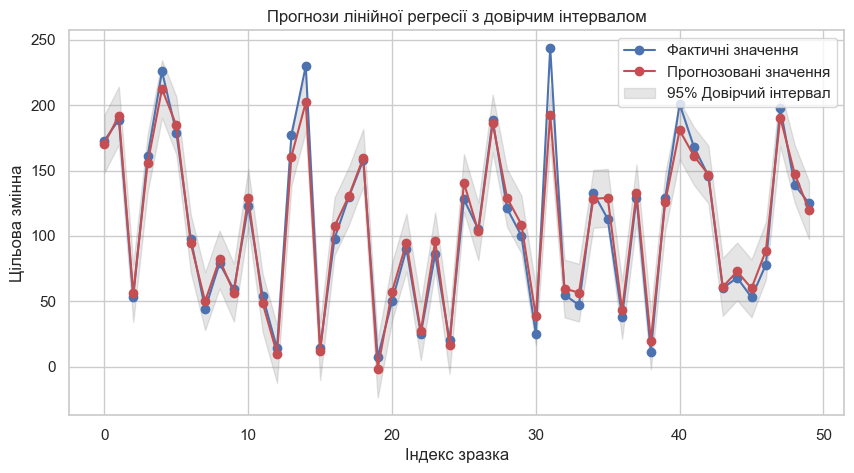

In [16]:
# Візуалізація прогнозів лінійної регресії з довірчими інтервалами для перших 50 зразків
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(y_pred_lr[:50], 'ro-', label='Прогнозовані значення')
plt.fill_between(np.arange(50), 
                 pred_summary['obs_ci_lower'][:50], 
                 pred_summary['obs_ci_upper'][:50], 
                 color='gray', alpha=0.2, label='95% Довірчий інтервал')
plt.legend()
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Прогнози лінійної регресії з довірчим інтервалом')
plt.show()

### 2.3 Перевіряємо якість моделей за параметрами

Gradient Boosting - MAE: 2.606, RMSE: 3.612, R²: 0.997
   Actual   Predicted  Lower Bound  Upper Bound
0   173.0  170.392495   108.462104   175.615323
1   189.0  193.559526   100.681281   204.657659
2    53.0   50.901286    43.974439    57.676007
3   161.0  163.205565   105.432852   171.493380
4   226.0  223.256632   108.462104   231.180316
5   179.0  180.552255   104.504992   204.416359
6    98.0   96.084023    69.635141    97.323238
7    44.0   43.496494    39.226143    48.099052
8    79.0   79.738852    72.362279    89.767043
9    59.0   57.412830    53.121550    65.680027


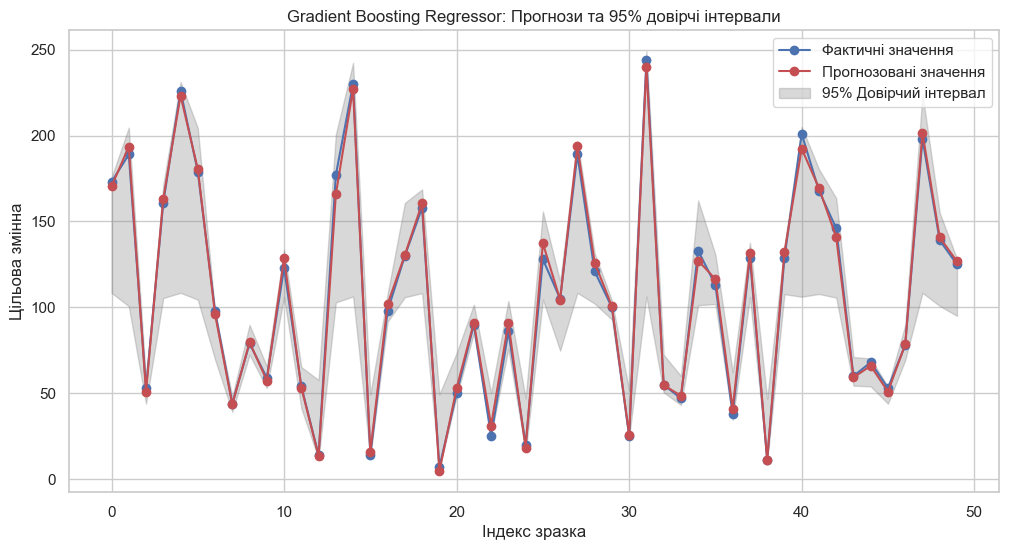

In [18]:
# Gradient Boosting Regressor (базова модель)
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_gb, rmse_gb, r2_gb))
# Обчислення довірчих інтервалів за допомогою квантильного градієнтного бустингу
# Навчаємо дві додаткові моделі для нижньої та верхньої меж (95% довірчий інтервал)

# Модель для нижньої межі (2.5-й процентиль)
gb_lower = GradientBoostingRegressor(loss='quantile', alpha=0.025, n_estimators=100, learning_rate=0.1, random_state=42)
gb_lower.fit(X_train_scaled, y_train)
y_pred_lower = gb_lower.predict(X_test_scaled)

# Модель для верхньої межі (97.5-й процентиль)
gb_upper = GradientBoostingRegressor(loss='quantile', alpha=0.975, n_estimators=100, learning_rate=0.1, random_state=42)
gb_upper.fit(X_train_scaled, y_train)
y_pred_upper = gb_upper.predict(X_test_scaled)

# Виведемо декілька прикладів прогнозів з довірчими інтервалами
results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_gb,
    'Lower Bound': y_pred_lower,
    'Upper Bound': y_pred_upper
})
print(results.head(10))
# Візуалізація прогнозів та довірчих інтервалів для перших 50 зразків
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, y_pred_gb[:50], 'ro-', label='Прогнозовані значення')
plt.fill_between(indices, y_pred_lower[:50], y_pred_upper[:50], color='gray', alpha=0.3, label='95% Довірчий інтервал')
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Gradient Boosting Regressor: Прогнози та 95% довірчі інтервали')
plt.legend()
plt.show()

Random Forest - MAE: 1.711, RMSE: 2.671, R²: 0.998
   Actual  Predicted  Min Prediction  Max Prediction
0   173.0     170.91           151.0           186.0
1   189.0     192.94           168.0           218.0
2    53.0      53.26            49.0            58.0
3   161.0     159.16           144.0           184.0
4   226.0     221.18           205.0           231.0
5   179.0     177.91           158.0           201.0
6    98.0      97.37            83.0           111.0
7    44.0      45.26            39.0            52.0
8    79.0      80.19            73.0            88.0
9    59.0      58.94            52.0            63.0


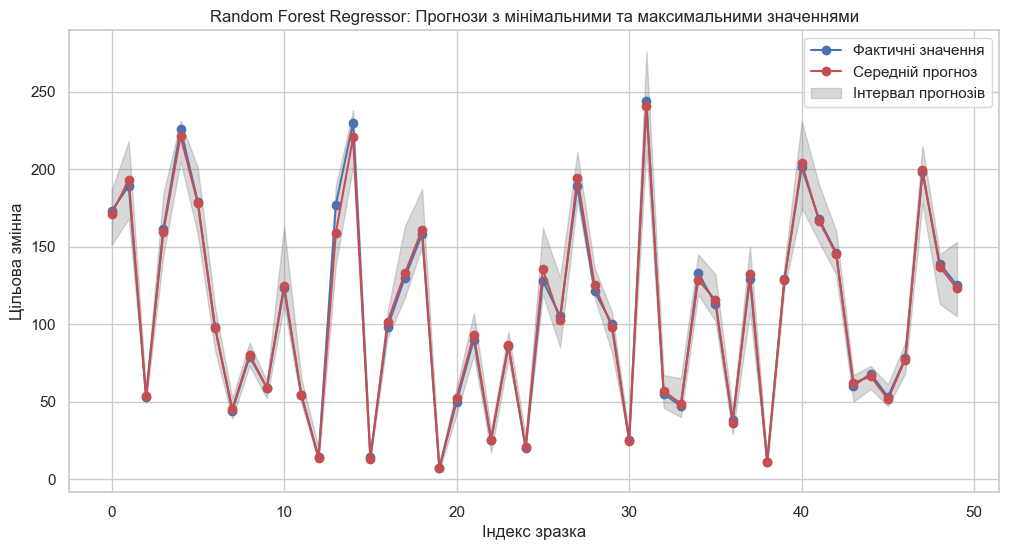

In [19]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_rf, rmse_rf, r2_rf))

# ---------------------------------------------------------
# Отримуємо прогнози окремих дерев для кожного зразка
# rf_model.estimators_ містить окремі дерева
tree_preds = np.array([tree.predict(X_test_scaled) for tree in rf_model.estimators_]).T

# Для кожного зразка знаходимо мінімальне та максимальне значення прогнозів
y_pred_min = tree_preds.min(axis=1)
y_pred_max = tree_preds.max(axis=1)

# Створимо DataFrame для порівняння: фактичні значення, середній прогноз, нижня та верхня межа прогнозу
results_rf = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_rf,
    'Min Prediction': y_pred_min,
    'Max Prediction': y_pred_max
})
print(results_rf.head(10))

# ---------------------------------------------------------
# Візуалізація прогнозів із мінімальними та максимальними значеннями для перших 50 зразків
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, y_pred_rf[:50], 'ro-', label='Середній прогноз')
plt.fill_between(indices, y_pred_min[:50], y_pred_max[:50], color='gray', alpha=0.3, label='Інтервал прогнозів')
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Random Forest Regressor: Прогнози з мінімальними та максимальними значеннями')
plt.legend()
plt.show()


Lasso Regression - MAE: 8.451, RMSE: 11.536, R²: 0.967


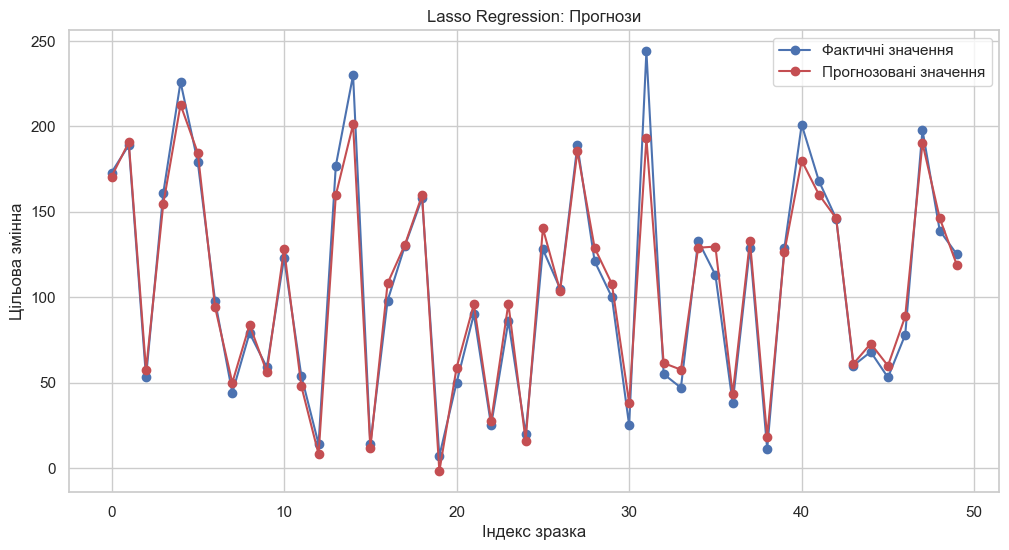

In [20]:
# Lasso Regression (базова модель)
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_lasso, rmse_lasso, r2_lasso))

# Для Lasso довірчі інтервали зазвичай не використовуються через регуляризацію, тому цей етап можна пропустити.

# Візуалізація прогнозів для Lasso
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, y_pred_lasso[:50], 'ro-', label='Прогнозовані значення')
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Lasso Regression: Прогнози')
plt.legend()
plt.show()

Ridge Regression - MAE: 8.441, RMSE: 11.489, R²: 0.967


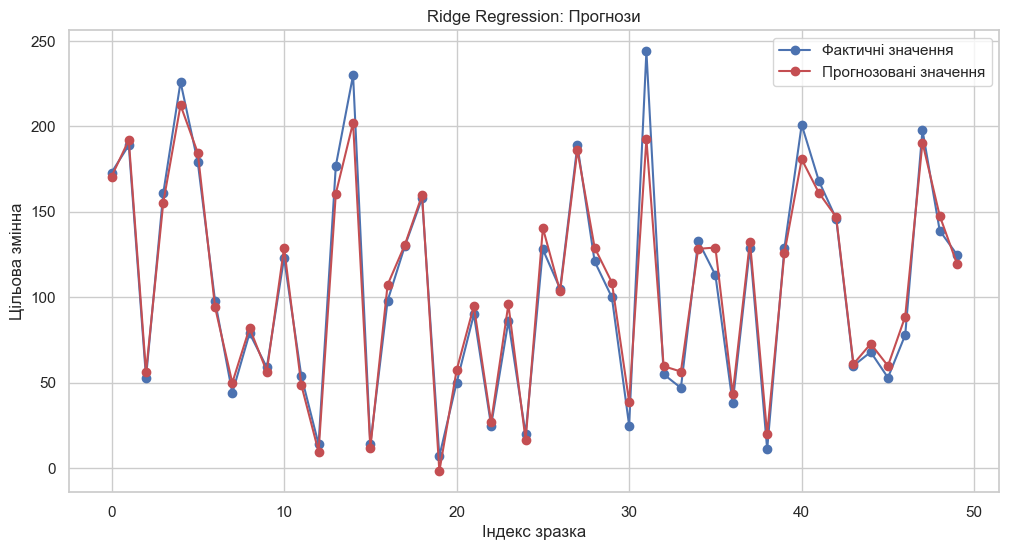

In [21]:
# Ridge Regression (базова модель)
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge Regression - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_ridge, rmse_ridge, r2_ridge))

# Для Ridge довірчі інтервали зазвичай не використовуються через регуляризацію, тому цей етап можна пропустити.

# Візуалізація прогнозів для Ridge
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, y_pred_ridge[:50], 'ro-', label='Прогнозовані значення')
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Ridge Regression: Прогнози')
plt.legend()
plt.show()

### 2.4 Оптимізація гіперпараметрів для моделей
- Використовуємо GridSearchCV та RandomizedSearchCV для пошуку найкращих параметрів

In [23]:
# Лінійна регресія з GridSearchCV (пошук найкращих гіперпараметрів)
lr_model = LinearRegression()
params_lr = {}  # Лінійна регресія зазвичай не має гіперпараметрів для оптимізації
grid_search_lr = GridSearchCV(lr_model, params_lr, cv=5, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_train_scaled, y_train)
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print("Лінійна регресія (оптимізована) - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_lr, rmse_lr, r2_lr))

# Random Forest Regressor (оптимізація через RandomizedSearchCV)
rf_model = RandomForestRegressor(random_state=42)
params_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=params_rf, n_iter=10, cv=5, n_jobs=-1, random_state=42)
random_search_rf.fit(X_train_scaled, y_train)
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Regressor (оптимізований) - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_rf, rmse_rf, r2_rf))

# Gradient Boosting Regressor (оптимізація через GridSearchCV)
gb_model = GradientBoostingRegressor(random_state=42)
params_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
grid_search_gb = GridSearchCV(gb_model, param_grid=params_gb, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train_scaled, y_train)
best_gb_model = grid_search_gb.best_estimator_
y_pred_gb = best_gb_model.predict(X_test_scaled)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting Regressor (оптимізований) - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_gb, rmse_gb, r2_gb))

Лінійна регресія (оптимізована) - MAE: 8.442, RMSE: 11.489, R²: 0.967
Random Forest Regressor (оптимізований) - MAE: 1.993, RMSE: 3.079, R²: 0.998
Gradient Boosting Regressor (оптимізований) - MAE: 1.007, RMSE: 1.394, R²: 1.000


In [24]:
# Lasso Regression (оптимізація через GridSearchCV)
lasso_model = Lasso(random_state=42)
params_lasso = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}
grid_search_lasso = GridSearchCV(lasso_model, param_grid=params_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_scaled, y_train)
best_lasso_model = grid_search_lasso.best_estimator_
y_pred_lasso = best_lasso_model.predict(X_test_scaled)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression (оптимізований) - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_lasso, rmse_lasso, r2_lasso))

# Ridge Regression (оптимізація через GridSearchCV)
ridge_model = Ridge(random_state=42)
params_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}
grid_search_ridge = GridSearchCV(ridge_model, param_grid=params_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_scaled, y_train)
best_ridge_model = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge Regression (оптимізований) - MAE: {:.3f}, RMSE: {:.3f}, R²: {:.3f}".format(mae_ridge, rmse_ridge, r2_ridge))


Lasso Regression (оптимізований) - MAE: 8.440, RMSE: 11.491, R²: 0.967
Ridge Regression (оптимізований) - MAE: 8.442, RMSE: 11.489, R²: 0.967


## 3. Перехід від регресії до класифікації
### 3.1 Перетворити регресію на класифікацію, розбивши цільову змінну на класи.

Ми перетворимо регресійне завдання у класифікаційне, розбивши цільову змінну на класи за допомогою equal-width binning.

In [27]:
# Використовуємо KBinsDiscretizer для рівномірного розбиття (наприклад, на 4 класи)
n_bins = 4
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_train_class = kbd.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_test_class = kbd.transform(y_test.values.reshape(-1, 1)).astype(int).ravel()

print("Розподіл класів у тренувальних даних:\n", pd.Series(y_train_class).value_counts())


Розподіл класів у тренувальних даних:
 0    6072
1    3867
2    1936
3     125
Name: count, dtype: int64


### 3.2 Навчаємо класифікатори
Навчимо Логістичну регресію, Decision Tree Classifier та XGBoost Classifier

In [29]:
# Побудова класифікаційних моделей
# Логістична регресія
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_class)
y_pred_logreg = logreg.predict(X_test_scaled)

# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_scaled, y_train_class)
y_pred_dtc = dtc.predict(X_test_scaled)

# XGBoost Classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_scaled, y_train_class)
y_pred_xgb = xgb_clf.predict(X_test_scaled)

### 3.3 Оцінити якість класифікації за метриками

Логістична регресія - Accuracy: 0.956, Precision: 0.956, Recall: 0.956, F1-score: 0.955

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1463
           1       0.94      0.93      0.94       978
           2       0.91      0.96      0.94       520
           3       0.96      0.67      0.79        39

    accuracy                           0.96      3000
   macro avg       0.95      0.88      0.91      3000
weighted avg       0.96      0.96      0.96      3000



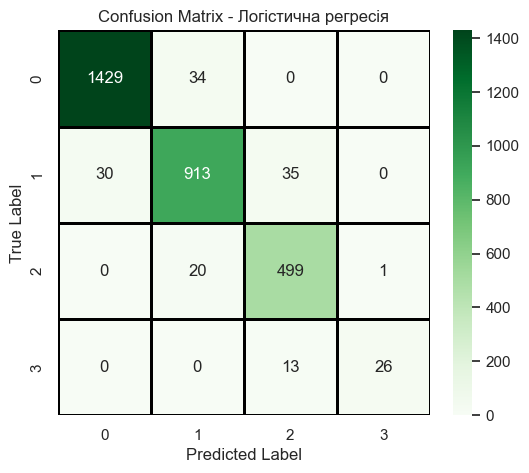

Decision Tree - Accuracy: 0.956, Precision: 0.956, Recall: 0.956, F1-score: 0.956

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1463
           1       0.95      0.94      0.94       978
           2       0.92      0.93      0.92       520
           3       0.76      0.72      0.74        39

    accuracy                           0.96      3000
   macro avg       0.90      0.89      0.90      3000
weighted avg       0.96      0.96      0.96      3000



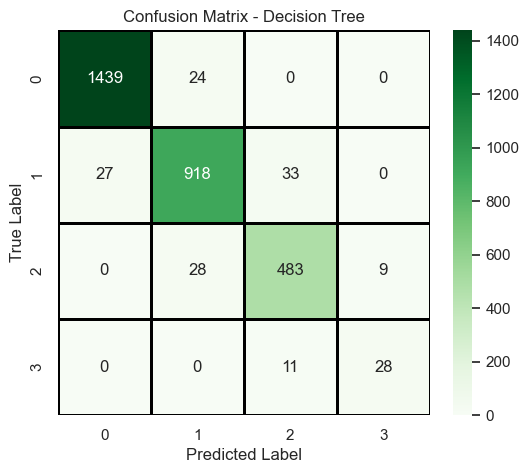

XGBoost - Accuracy: 0.980, Precision: 0.980, Recall: 0.980, F1-score: 0.980

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1463
           1       0.98      0.97      0.97       978
           2       0.95      0.97      0.96       520
           3       0.94      0.79      0.86        39

    accuracy                           0.98      3000
   macro avg       0.96      0.93      0.95      3000
weighted avg       0.98      0.98      0.98      3000



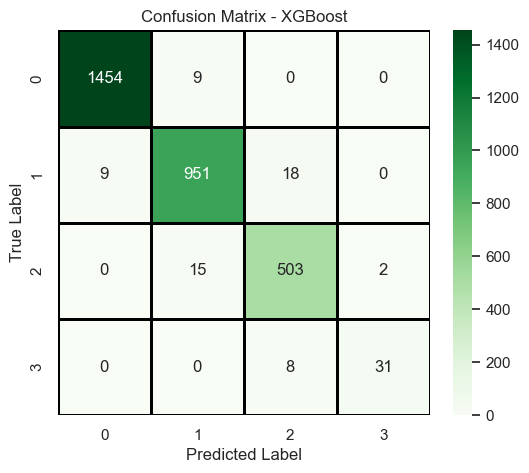

In [31]:
def print_classification_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{model_name} - Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1-score: {f1:.3f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Візуалізація матриці помилок
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', linewidths=1, linecolor='black')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Виклик функції для моделей
print_classification_metrics(y_test_class, y_pred_logreg, "Логістична регресія")
print_classification_metrics(y_test_class, y_pred_dtc, "Decision Tree")
print_classification_metrics(y_test_class, y_pred_xgb, "XGBoost")

### 3.4 Повторити кроки 1-3 використовуючи інший крок дискретизації 

Розподіл класів (6 класів) у тренувальних даних:
 0    4362
1    3112
2    2465
3    1650
4     385
5      26
Name: count, dtype: int64
Логістична регресія (6 класів) - Accuracy: 0.928, Precision: 0.927, Recall: 0.928, F1-score: 0.926

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1067
           1       0.92      0.92      0.92       765
           2       0.91      0.89      0.90       609
           3       0.86      0.95      0.90       437
           4       0.91      0.69      0.78       116
           5       0.00      0.00      0.00         6

    accuracy                           0.93      3000
   macro avg       0.76      0.74      0.75      3000
weighted avg       0.93      0.93      0.93      3000



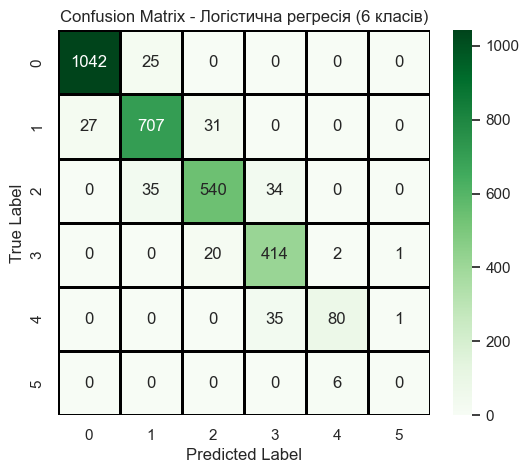

Decision Tree (6 класів) - Accuracy: 0.924, Precision: 0.925, Recall: 0.924, F1-score: 0.924

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1067
           1       0.93      0.92      0.92       765
           2       0.90      0.90      0.90       609
           3       0.88      0.89      0.89       437
           4       0.79      0.77      0.78       116
           5       0.44      0.67      0.53         6

    accuracy                           0.92      3000
   macro avg       0.82      0.85      0.83      3000
weighted avg       0.92      0.92      0.92      3000



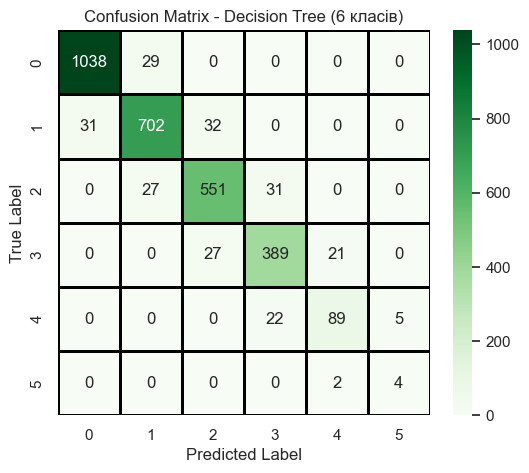

XGBoost (6 класів) - Accuracy: 0.960, Precision: 0.960, Recall: 0.960, F1-score: 0.960

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1067
           1       0.96      0.96      0.96       765
           2       0.95      0.94      0.95       609
           3       0.93      0.94      0.93       437
           4       0.90      0.88      0.89       116
           5       1.00      0.67      0.80         6

    accuracy                           0.96      3000
   macro avg       0.95      0.90      0.92      3000
weighted avg       0.96      0.96      0.96      3000



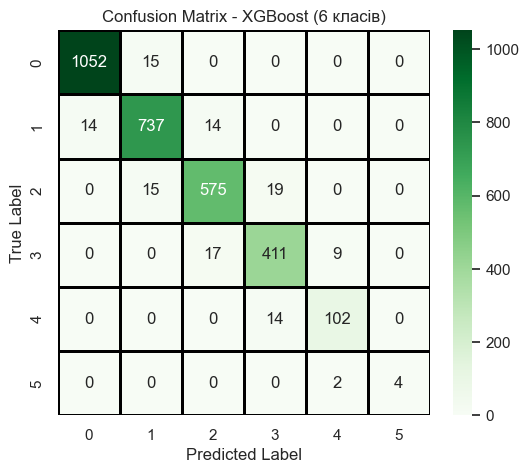

In [33]:
# Дискретизація цільової змінної в 6 класів
n_bins_alt = 6
kbd_alt = KBinsDiscretizer(n_bins=n_bins_alt, encode='ordinal', strategy='uniform')
y_train_class_alt = kbd_alt.fit_transform(y_train.values.reshape(-1, 1)).astype(int).ravel()
y_test_class_alt = kbd_alt.transform(y_test.values.reshape(-1, 1)).astype(int).ravel()

print("Розподіл класів (6 класів) у тренувальних даних:\n", pd.Series(y_train_class_alt).value_counts())

# Перенавчання моделей на нових класах
logreg_alt = LogisticRegression(max_iter=1000, random_state=42)
logreg_alt.fit(X_train_scaled, y_train_class_alt)
y_pred_logreg_alt = logreg_alt.predict(X_test_scaled)
print_classification_metrics(y_test_class_alt, y_pred_logreg_alt, "Логістична регресія (6 класів)")

# Decision Tree Classifier
dtc_alt = DecisionTreeClassifier(random_state=42)
dtc_alt.fit(X_train_scaled, y_train_class_alt)
y_pred_dtc_alt = dtc_alt.predict(X_test_scaled)
print_classification_metrics(y_test_class_alt, y_pred_dtc_alt, "Decision Tree (6 класів)")

# XGBoost Classifier
xgb_clf_alt = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf_alt.fit(X_train_scaled, y_train_class_alt)
y_pred_xgb_alt = xgb_clf_alt.predict(X_test_scaled)
print_classification_metrics(y_test_class_alt, y_pred_xgb_alt, "XGBoost (6 класів)")


## 4. Дослідження розподілу ймовірностей у класифікації

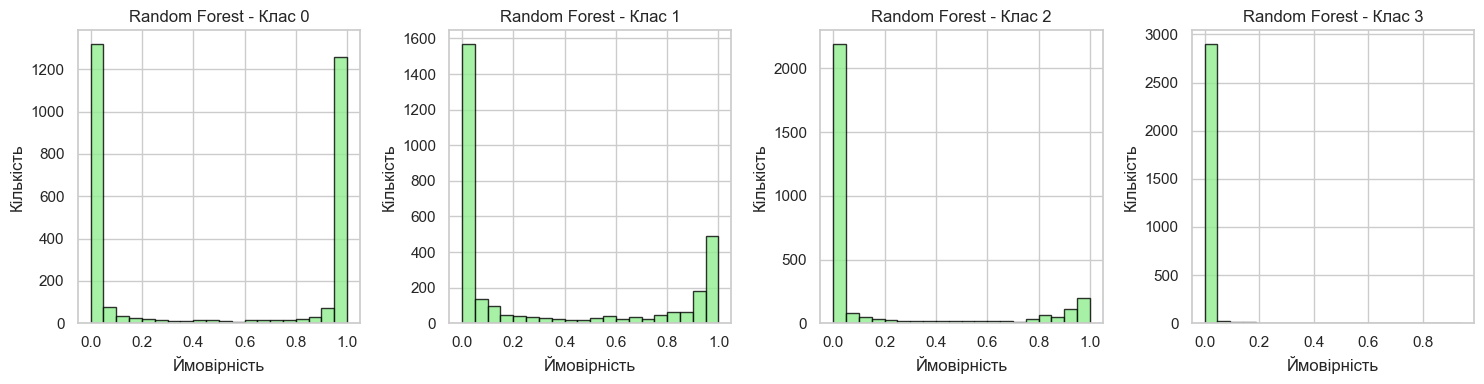

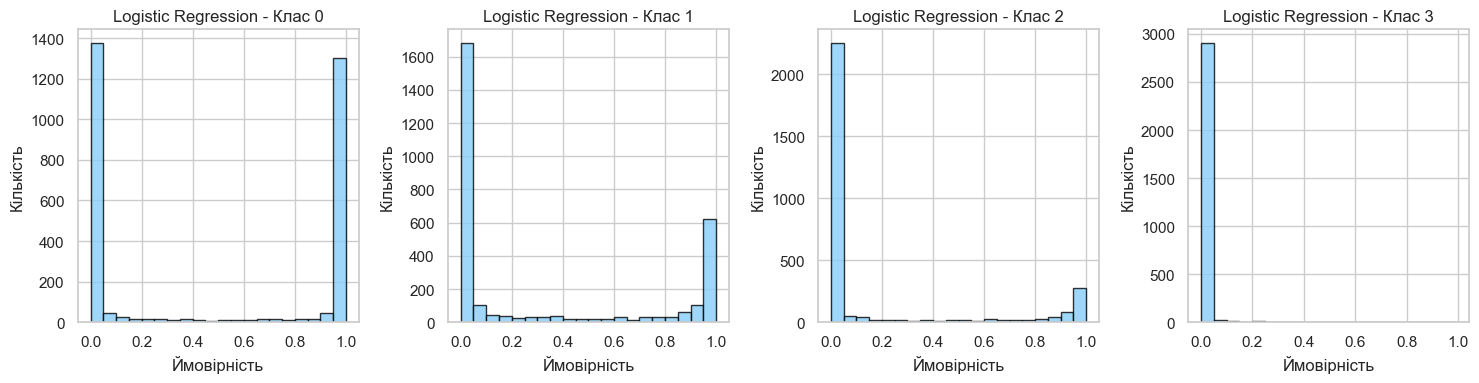

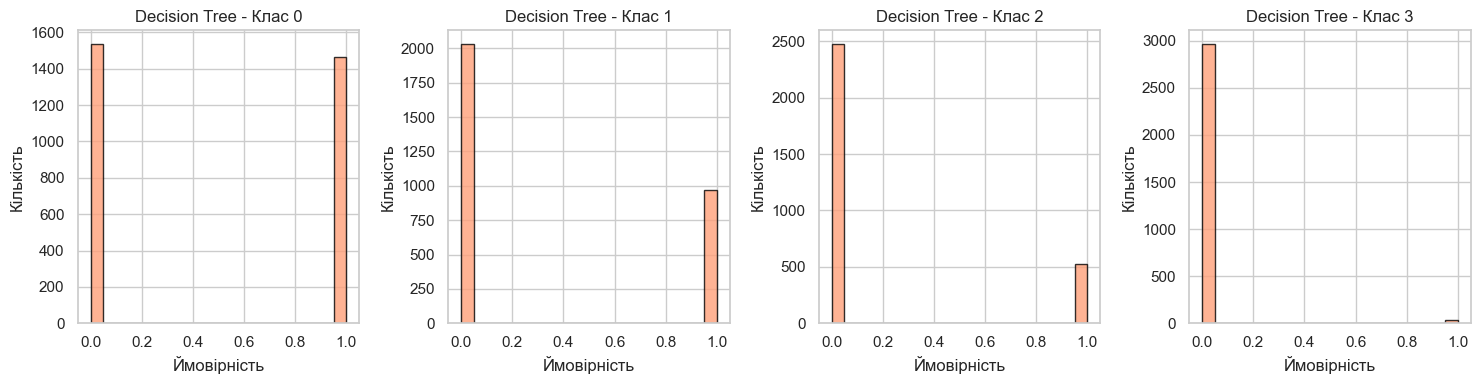

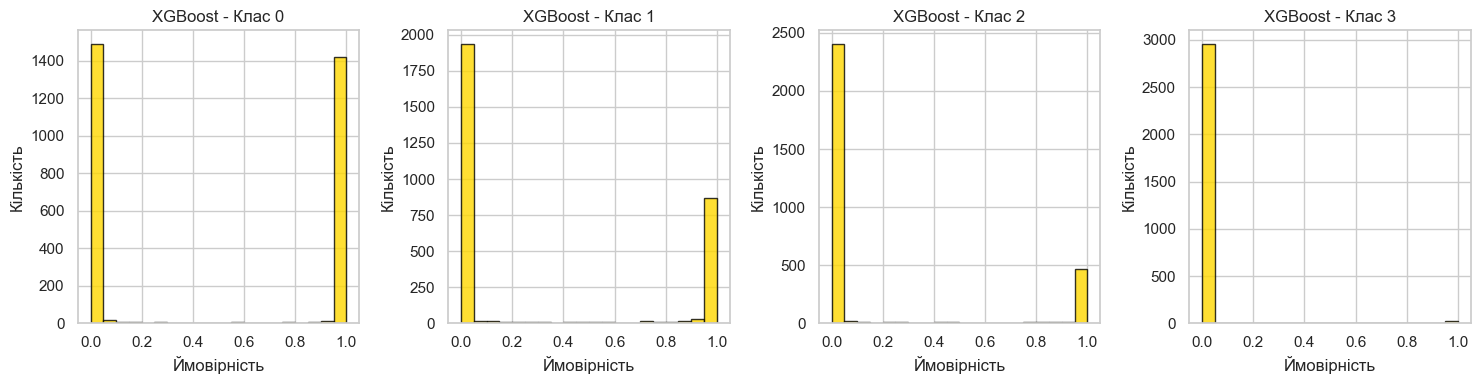

In [35]:
from sklearn.ensemble import RandomForestClassifier
# Навчаємо Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train_class)
y_proba_rf = rf_clf.predict_proba(X_test_scaled)

# Логістична регресія
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_class)
y_proba_logreg = logreg.predict_proba(X_test_scaled)

# Decision Tree
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train_scaled, y_train_class)
y_proba_dtc = dtc.predict_proba(X_test_scaled)

# XGBoost
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_scaled, y_train_class)
y_proba_xgb = xgb_clf.predict_proba(X_test_scaled)

# Список моделей та кольорів
models = {
    "Random Forest": (y_proba_rf, "#90EE90"),  # Ніжно-зелений
    "Logistic Regression": (y_proba_logreg, "#87CEFA"),  # Блакитний
    "Decision Tree": (y_proba_dtc, "#FFA07A"),  # Світло-червоний (лососевий)
    "XGBoost": (y_proba_xgb, "#FFD700")  # Золотий
}

# Побудова графіків
for model_name, (y_proba, color) in models.items():
    plt.figure(figsize=(15, 4))
    for i in range(y_proba.shape[1]):  # Кількість класів
        plt.subplot(1, y_proba.shape[1], i + 1)
        plt.hist(y_proba[:, i], bins=20, color=color, edgecolor='black', alpha=0.8)
        plt.title(f"{model_name} - Клас {i}")
        plt.xlabel("Ймовірність")
        plt.ylabel("Кількість")
    plt.tight_layout()
    plt.show()

# Аналіз розподілу ймовірностей може показати, як модель впевнено/невпевнено класифікує зразки.
# При overfitting часто спостерігається надмірна впевненість (ймовірності близькі до 0 або 1),
# тоді як при underfitting розподіл буде більш рівномірним.

## 5. Оптимізація класифікатора

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Найкращі параметри для Random Forest: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Оптимізований Random Forest - Accuracy: 0.972, Precision: 0.972, Recall: 0.972, F1-score: 0.972

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1463
           1       0.96      0.97      0.96       978
           2       0.95      0.95      0.95       520
           3       0.97      0.72      0.82        39

    accuracy                           0.97      3000
   macro avg       0.97      0.91      0.93      3000
weighted avg       0.97      0.97      0.97      3000



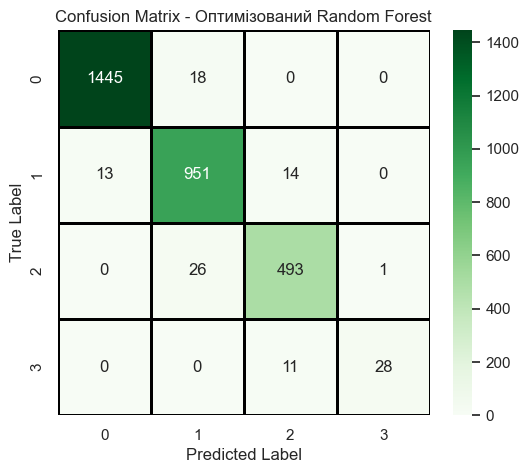

In [37]:
# Налаштовуємо сітку параметрів для GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Кількість дерев у лісі
    'max_depth': [5, 10, 20, None],  # Глибина дерева
    'min_samples_split': [2, 5, 10],  # Мінімальна кількість зразків для поділу
    'min_samples_leaf': [1, 2, 4],  # Мінімальна кількість зразків у листі
    'bootstrap': [True, False]  # Використання бутстрепа
}

# Виконуємо крос-валідацію для підбору найкращих параметрів
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid_rf,
                              cv=5,  # 5-фолд крос-валідація
                              scoring='accuracy',
                              n_jobs=-1,  # Використання всіх процесорів
                              verbose=1)  # Відображення процесу

# Навчання моделі на тренувальних даних
grid_search_rf.fit(X_train_scaled, y_train_class)

# Вивід найкращих параметрів
print("Найкращі параметри для Random Forest:", grid_search_rf.best_params_)

# Оцінка оптимізованої моделі
rf_opt = grid_search_rf.best_estimator_
y_pred_rf_opt = rf_opt.predict(X_test_scaled)
print_classification_metrics(y_test_class, y_pred_rf_opt, "Оптимізований Random Forest")


## 6. Перетворення метрик між регресією та класифікацією

In [63]:
# Порівняння регресії та класифікації
print("Порівняння:")
print("Регресійна задача регресії (наприклад, Random Forest): RMSE = {:.3f}".format(rmse_rf))
print("Класифікаційна задача (оптимізований Random Forest): Accuracy = {:.3f}".format(accuracy_score(y_test_class, y_pred_rf_opt)))


# Висновки:
# - Порівнюючи результати, можна визначити, чи дає дискретизація цільової змінної (класифікація)
#   кращі результати, чи ж регресія є більш інформативною.
# - Розподіл ймовірностей показав, як модель впевнено робить прогнози.
# - Ансамблеві підходи (Stacking, Random Forest, Gradient Boosting) здатні покращити результати за відповідними метриками.

Порівняння:
Регресійна задача регресії (наприклад, Random Forest): RMSE = 3.079
Класифікаційна задача (оптимізований Random Forest): Accuracy = 0.972


In [67]:
# Порівняння регресії та класифікації

print("=== Порівняння ===")
print("Регресійна задача (Random Forest):")
print("  RMSE = {:.3f}".format(rmse_rf))
print("  MAE  = {:.3f}".format(mae_rf))
print("")
print("Класифікаційна задача (Оптимізований Random Forest):")
acc_clf = accuracy_score(y_test_class, y_pred_rf_opt)
print("  Accuracy = {:.3f}".format(acc_clf))

# Обчислюємо ширину класу (w) та розмах цільової змінної (R)
# Для дискретизації використовувалось n_bins = 4
n_bins = 4
y_min, y_max = y_test.min(), y_test.max()
R = y_max - y_min          # розмах цільової змінної
w = R / n_bins             # ширина кожного класу

# 1. Перетворення MAE регресії у точність класифікації:
# Формула: accuracy ≈ 1 - (MAE / w)
acc_from_mae = 1 - (mae_rf / w)

# 2. Перетворення точності класифікації у MAE:
# Формула: MAE ≈ (1 - accuracy)*R + (w / 2)
mae_from_acc = (1 - acc_clf) * R + (w / 2)

print("\n=== Перетворення за формулами ===")
print("З MAE регресії ({:.3f}) отримуємо приблизну точність: {:.3f}".format(mae_rf, acc_from_mae))
print("   (Формула: accuracy ≈ 1 - MAE/w, де w = {:.2f})".format(w))
print("")
print("З точності класифікації ({:.3f}) отримуємо приблизну MAE: {:.3f}".format(acc_clf, mae_from_acc))
print("   (Формула: MAE ≈ (1 - accuracy)*R + w/2, де R = {:.2f}, w = {:.2f})".format(R, w))


=== Порівняння ===
Регресійна задача (Random Forest):
  RMSE = 3.079
  MAE  = 1.993

Класифікаційна задача (Оптимізований Random Forest):
  Accuracy = 0.972

=== Перетворення за формулами ===
З MAE регресії (1.993) отримуємо приблизну точність: 0.973
   (Формула: accuracy ≈ 1 - MAE/w, де w = 73.50)

З точності класифікації (0.972) отримуємо приблизну MAE: 44.884
   (Формула: MAE ≈ (1 - accuracy)*R + w/2, де R = 294.00, w = 73.50)


Точність дискретизованих прогнозів регресії = 0.982
MAE для регресії після заміни дискретизованих прогнозів середніми значеннями класів = 18.93060009129849


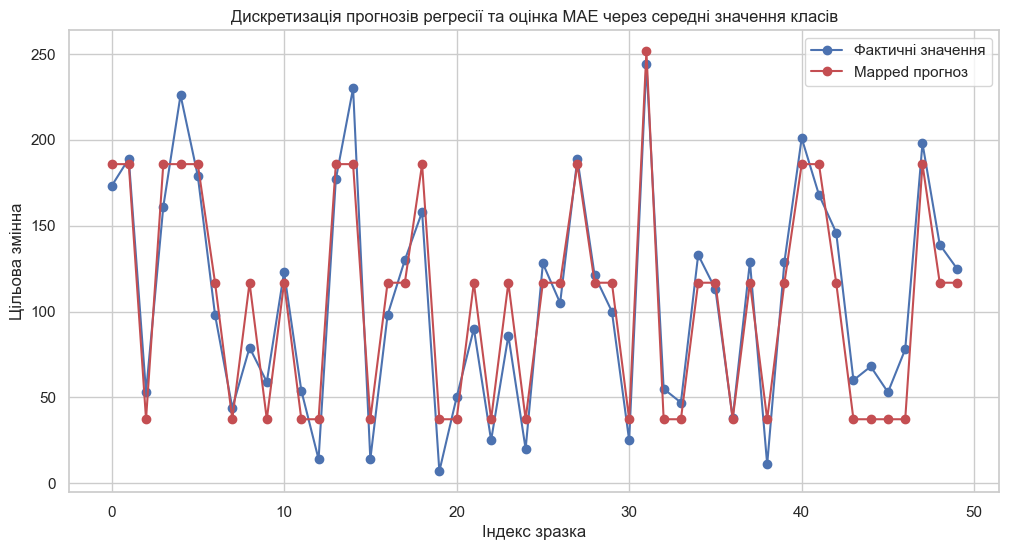

In [69]:

# Використовуємо KBinsDiscretizer, який застосовувався для формування класів (наприклад, n_bins = 4)
# Дискретизуємо регресійні прогнозування з Random Forest
reg_pred_class = kbd.transform(y_pred_rf.reshape(-1, 1)).astype(int).ravel()

# Обчислюємо точність дискретизованих прогнозів порівняно з фактичними класами
accuracy_reg_pred = accuracy_score(y_test_class, reg_pred_class)
print("Точність дискретизованих прогнозів регресії =", accuracy_reg_pred)

# ----- Оцінка MAE через середні значення класів -----

# Обчислюємо середнє значення цільової змінної для кожного класу (на тренувальних даних)
# y_train_class вже отриманий раніше при дискретизації y_train
class_means = {}
for cls in range(n_bins):
    # Якщо у класі є спостереження, обчислюємо середнє; інакше використовуємо середину інтервалу
    cls_vals = y_train[y_train_class == cls]
    if len(cls_vals) > 0:
        class_means[cls] = cls_vals.mean()
    else:
        # Визначаємо середину інтервалу для цього класу
        bin_edges = kbd.bin_edges_[0]
        class_means[cls] = (bin_edges[cls] + bin_edges[cls+1]) / 2

# Замапуємо дискретизовані прогнозування у середні значення відповідних класів
mapped_reg_pred = np.array([class_means[cls] for cls in reg_pred_class])

# Обчислюємо MAE між замапованими прогнозами та фактичними значеннями
mae_mapped = np.mean(np.abs(y_test.values - mapped_reg_pred))
print("MAE для регресії після заміни дискретизованих прогнозів середніми значеннями класів =", mae_mapped)

# Візуалізація: порівняння фактичних значень та "mapped" прогнозів для перших 50 зразків
plt.figure(figsize=(12,6))
indices = np.arange(50)
plt.plot(indices, y_test.values[:50], 'bo-', label='Фактичні значення')
plt.plot(indices, mapped_reg_pred[:50], 'ro-', label='Mapped прогноз')
plt.xlabel('Індекс зразка')
plt.ylabel('Цільова змінна')
plt.title('Дискретизація прогнозів регресії та оцінка MAE через середні значення класів')
plt.legend()
plt.show()


### Висновок:
* Використовувала багато різних моделей та метрики для них. Основні моделі для регресії - Лінійну регресію, 
Random Forest Regresso, 
Gradient Boosting Reessor, r
Lasso та Ri. Основні моделі для класифікації - Random Forest, Логістична регресія, Decision Tree, XGBoost.
* Для регресії основні метрики - MAE, RMSE, R². Для класифікації - Accuracy, Precision, Recall, F1-score.
* Для перехіду від регресії до класифікації ми використовували дискретизацію цільової змінної, тобто розбивали проміжок на якому знаходиться цільова змінна на певні частинки і тоді утворюються класи.
* Також можемо перевести метрики регресії у метрики класифікації за допомогою формул або дискретизації.
* Всі моделі, які я використовувала є дуже хорошими їхні результати не сильно відрізняються один від одного. Датасет був дуже легенький та легко опрацьовувався.sor